## Model stuffs

In [1]:
import torch.nn as nn
import torch
from einops import rearrange

In [2]:
# initialize wandb logger
import wandb
import os
import time

from portiloop_software.portiloop_python.ANN.utils import set_seeds

project_name = "sleep_staging_portiloop"

os.environ['WANDB_API_KEY'] = "a74040bb77f7705257c1c8d5dc482e06b874c5ce"
os.environ['WANDB_NOTEBOOK_NAME '] = "sleep_staging_training.ipynb"
seed = 42
set_seeds(seed)

In [3]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [4]:
class TransformerEncoderWithCLS(nn.Module):
    def __init__(self, embedder, embedding_size, num_heads, num_layers, num_classes, cls=False, dropout=0.1):
        super(TransformerEncoderWithCLS, self).__init__()

        self.embedder = embedder

        self.positional_embedding = PositionalEncoding(embedding_size, dropout=dropout)

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_size, num_heads, dropout=dropout, batch_first=True),
            num_layers
        )
        self.cls = cls
        if cls:
            self.cls_token = nn.Parameter(torch.randn(1, embedding_size, 1))  # Learnable <cls> token
        self.activation = nn.ReLU()
        self.classifier = nn.Linear(embedding_size, num_classes)  # Classification layer
        self.final_activation = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        x = self.dropout(self.embedder(x))  # Embed the input sequence
        batch_size, embedding_size, seq_len = x.size()

        # Add positional embedding
        x = rearrange(x, 'b e s -> s b e')
        x = self.positional_embedding(x)
        x = rearrange(x, 's b e -> b e s')

        if self.cls:
            cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # Shape: (batch_size, 1, embedding_size)
            x = torch.cat([cls_tokens, x], dim=-1)  # Shape: (batch_size, seq_length + 1, embedding_size)

        x = rearrange(x, 'b e s -> b s e')

        output = self.transformer_encoder(x)  # Apply TransformerEncoder
        
        if self.cls:
            output = output[:, 0, :]  # Return the representation of the <cls> token
        else:
            output = torch.mean(output, dim=1)

        out = self.dropout(self.classifier(output)) # Classify the <cls> token representation

        return out 


In [5]:
class SimpleModel(nn.Module):
    def __init__(self, seq_len, hidden_dim, num_classes):
        super(SimpleModel, self).__init__()
        
        # self.embedding = nn.Embedding(seq_len, hidden_dim)
        self.hidden_layer = nn.Linear(seq_len, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = x.squeeze(1)
        x = self.hidden_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [6]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionBlock, self).__init__()

        # 1x1 convolution branch
        self.branch1x1 = nn.Conv1d(in_channels, out_channels[0], kernel_size=1)

        # 3x3 convolution branch
        self.branch3x3 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels[1], kernel_size=1),
            nn.Conv1d(out_channels[1], out_channels[2], kernel_size=3, padding=1)
        )

        # 5x5 convolution branch
        self.branch5x5 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels[3], kernel_size=1),
            nn.Conv1d(out_channels[3], out_channels[4], kernel_size=5, padding=2)
        )

        # # Max pooling branch
        # self.branch_pool = nn.Sequential(
        #     nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
        #     nn.Conv1d(in_channels, out_channels[5], kernel_size=1)
        # )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        # branch_pool = self.branch_pool(x)

        # Concatenate the branch outputs along the channel dimension
        outputs = [branch1x1, branch3x3, branch5x5]
        outputs = torch.cat(outputs, dim=1)
        outputs = rearrange(outputs, 'b c s -> b s c')  # Convert back to (batch_size, seq_len, channels)

        return outputs
    
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNBlock, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=5)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=5)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=5)

        self.activation = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.activation(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.activation(x)
        x = self.pool(x)

        return x

In [7]:
import random
from torch.utils.data import Dataset, DataLoader, Sampler

class SleepStageDataset(Dataset):
    def __init__(self, subjects, data, labels, seq_len, freq):
        '''
        This class takes in a list of subject, a path to the MASS directory 
        and reads the files associated with the given subjects as well as the sleep stage annotations
        '''
        super().__init__()

        self.seq_len = seq_len

        # Get the sleep stage labels
        self.full_signal = []
        self.full_labels = []

        self.subject_list = []
        for subject in subjects:
            if subject not in data.keys():
                print(f"Subject {subject} not found in the pretraining dataset")
                continue

            # Get the signal for the given subject
            signal = torch.tensor(data[subject]['signal'], dtype=torch.float)

            # Get all the labels for the given subject
            label = torch.tensor([SleepStageDataset.get_labels().index(lab) for lab in labels[subject]]).type(torch.uint8)

            # Repeat the labels freq times to match the signal using a pytorch function
            label = torch.tensor(label).repeat_interleave(freq) 

            # Add some '?' padding at the end to make sure the length of signal and label match
            missing = len(signal) - len(label)
            label = torch.cat([label, torch.full((missing, ), SleepStageDataset.get_labels().index('?')).type(torch.uint8)])

            # Make sure that the signal and the labels are the same length
            assert len(signal) == len(label)

            # Add to full signal and full label
            self.full_labels.append(label)
            self.full_signal.append(signal)
            del data[subject], signal, label
        
        self.full_signal = torch.cat(self.full_signal)
        self.full_labels = torch.cat(self.full_labels)

        # Make a dictionary of all the indexes of each class label
        self.label_indexes = {}
        for label in self.full_labels.unique():
            self.label_indexes[int(label)] = (self.full_labels == label).nonzero(as_tuple=False).reshape(-1)

    @staticmethod
    def get_labels():
        return ['1', '2', '3', 'R', 'W', '?']

    def __getitem__(self, index):
        # Get data and label at the given index
        signal = self.full_signal[index - self.seq_len:index]
        label = self.full_labels[index]
        signal = signal.unsqueeze(0)

        return signal, label.type(torch.LongTensor)

    def __len__(self):
        return len(self.full_signal)
    
class SleepStageSampler(Sampler):
    def __init__(self, dataset, seq_len, nb_batch_per_epoch, batch_size):
        self.dataset = dataset
        self.seq_len = seq_len
        self.max_len = len(dataset)
        self.limit = nb_batch_per_epoch * batch_size
        self.nb_batch_per_epoch = nb_batch_per_epoch

    def __iter__(self):
        for i in range(self.limit): 
            # Get a random class between 0 and 4
            sample_class = random.randint(0, 4)

            # Get a random index from the list of indexes for the given class
            sample_index = random.choice(self.dataset.label_indexes[sample_class])

            yield sample_index

    def __len__(self):
        return self.nb_batch_per_epoch

In [8]:
class ArtificialEEGDataset(Dataset):
    def __init__(self, num_classes, signal_length, noise_std=0.5):
        self.num_classes = num_classes
        self.signal_length = signal_length
        self.noise_std = noise_std
        self.data, self.labels = self.generate_data()

    def generate_data(self):
        t = np.linspace(0, 2 * np.pi, self.signal_length)
        # Expand the dimension of t to make it compatible with the shape of the signal
        t = np.expand_dims(t, axis=0)
        # Duplicate the first dimension num_samples times
        t = np.repeat(t, self.num_classes, axis=0)
        # Get the random multiplier of for each sequence
        labels = np.array([1, 2, 3, 4, 5])
        t = t * labels[:, np.newaxis] * 10
        # Add spme noise to the signal
        signal = np.sin(t)
        labels = labels - 1

        data = torch.tensor(signal, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        return data, labels

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        data = self.data[index].unsqueeze(0)
        # Add noise to the data
        # data = data + torch.randn_like(data) * self.noise_std
        return data, self.labels[index]
    
class ArtificialEEGSampler(Sampler):
    def __init__(self, num_batches, batch_size):
        self.num_samples = num_batches * batch_size

    def __iter__(self):
        for _ in range(self.num_samples):
            yield np.random.choice([0, 1, 2, 3, 4])

    def __len__(self):
        return self.num_samples
    

In [9]:
import torch.optim as optim
from tqdm import tqdm 

def train_epoch(model, data_loader, loss_function, optimizer, device):
    model.train()
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)

        loss = loss_function(outputs, labels)
        # loss = loss.mean()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_loss /= len(data_loader)
    accuracy = correct_predictions / total_predictions

    return epoch_loss, accuracy

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def evaluate(model, data_loader, criterion):
    model.eval()

    total_loss = 0
    total_correct = 0
    total_samples = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(data_loader):
            X, y = batch
            X = X.to(device)
            y = y.to(device)

            out = model(X)

            prediction = torch.argmax(out, dim=1)

            y_true.append(y.cpu())
            y_pred.append(prediction)
            loss = criterion(out, y)
            total_loss += loss.item()
            total_correct += torch.sum(prediction == y)
            total_samples += len(X)

    loss  = total_loss / len(data_loader)
    accuracy = total_correct / total_samples

    y_true = torch.cat(y_true).cpu().numpy()
    y_pred = torch.cat(y_pred).cpu().numpy()

    print(np.unique(y_true, return_counts=True))

    conf_mat = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, target_names=SleepStageDataset.get_labels()[:-1], output_dict=True)
    return loss, accuracy, conf_mat, class_report

## Data

In [11]:
import time

import numpy as np

from portiloop_software.portiloop_python.ANN.utils import get_configs

from portiloop_software.portiloop_python.ANN.data.mass_data import read_pretraining_dataset, read_sleep_staging_labels, read_spindle_trains_labels
import torch


experiment_name = 'test_sleep_staging'
seed = 42

config = get_configs(experiment_name, False, seed)
# config['nb_conv_layers'] = 4
# config['hidden_size'] = 64
# config['nb_rnn_layers'] = 4

# Run some testing on subject 1
# Load the data
labels = read_spindle_trains_labels(config['old_dataset'])
ss_labels = read_sleep_staging_labels(config['path_dataset'])
# for index, patient_id in enumerate(ss_labels.keys()):
unfiltered_mass = "/project/portiloop_transformer/transformiloop/dataset/MASS_preds/"

data = read_pretraining_dataset(unfiltered_mass, patients_to_keep=['01-01-0001', '01-01-0002', '01-01-0003', '01-01-0004', '01-01-0005'])

## Experiment Code

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
config = {
    'batch_size': 128, 
    'freq': 250, 
    'inception': [16, 8, 16, 16, 32, 16], 
    'lr': 0.00005,
    'num_heads': 8,
    'num_layers': 1,
    'noise_std': 0.1,
    'dropout': 0.1,
}

config['seq_len'] = 25 * config['freq']
config['embedding_size'] = config['inception'][0] + config['inception'][2] + config['inception'][4]

In [14]:
# encoder = InceptionBlock(1, config['inception'])
encoder = CNNBlock(1, config['embedding_size'])

transformer = TransformerEncoderWithCLS(
    encoder, 
    config['embedding_size'], 
    config['num_heads'], 
    config['num_layers'], 
    5, 
    dropout=config['dropout'],
    cls=True)

from torchsummary import summary
summary(transformer, (1, config['seq_len']))

Layer (type:depth-idx)                        Output Shape              Param #
├─CNNBlock: 1-1                               [-1, 64, 777]             --
|    └─Conv1d: 2-1                            [-1, 64, 6246]            384
|    └─ReLU: 2-2                              [-1, 64, 6246]            --
|    └─MaxPool1d: 2-3                         [-1, 64, 3123]            --
|    └─Conv1d: 2-4                            [-1, 64, 3119]            20,544
|    └─ReLU: 2-5                              [-1, 64, 3119]            --
|    └─MaxPool1d: 2-6                         [-1, 64, 1559]            --
|    └─Conv1d: 2-7                            [-1, 64, 1555]            20,544
|    └─ReLU: 2-8                              [-1, 64, 1555]            --
|    └─MaxPool1d: 2-9                         [-1, 64, 777]             --
├─Dropout: 1-2                                [-1, 64, 777]             --
├─PositionalEncoding: 1-3                     [-1, 2, 64]               --
|    └─Drop

Layer (type:depth-idx)                        Output Shape              Param #
├─CNNBlock: 1-1                               [-1, 64, 777]             --
|    └─Conv1d: 2-1                            [-1, 64, 6246]            384
|    └─ReLU: 2-2                              [-1, 64, 6246]            --
|    └─MaxPool1d: 2-3                         [-1, 64, 3123]            --
|    └─Conv1d: 2-4                            [-1, 64, 3119]            20,544
|    └─ReLU: 2-5                              [-1, 64, 3119]            --
|    └─MaxPool1d: 2-6                         [-1, 64, 1559]            --
|    └─Conv1d: 2-7                            [-1, 64, 1555]            20,544
|    └─ReLU: 2-8                              [-1, 64, 1555]            --
|    └─MaxPool1d: 2-9                         [-1, 64, 777]             --
├─Dropout: 1-2                                [-1, 64, 777]             --
├─PositionalEncoding: 1-3                     [-1, 2, 64]               --
|    └─Drop

Get the data:

In [15]:
from torch.utils.data import RandomSampler

dataset = SleepStageDataset(['01-01-0001', '01-01-0002', '01-01-0003', '01-01-0004'], data, ss_labels, config['seq_len'], config['freq'])
test_dataset = SleepStageDataset(['01-01-0005'], data, ss_labels, config['seq_len'], config['freq'])
sampler = SleepStageSampler(dataset, config['seq_len'], 1000, config['batch_size'])
test_sampler = SleepStageSampler(test_dataset, config['seq_len'], 1000, config['batch_size'])

# dataset = ArtificialEEGDataset(5, config['seq_len'], noise_std=config['noise_std'])
# sampler = ArtificialEEGSampler(1000, config['batch_size'])

loader = DataLoader(
    dataset=dataset,
    batch_size=config['batch_size'],
    sampler=sampler,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=config['batch_size'],
    sampler=test_sampler,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

/tmp/ipykernel_1012812/3033477500.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).repeat_interleave(freq)


In [16]:
dataset[1000000][0][0]

tensor([ 1.5170,  3.2430,  6.0444,  ..., -0.4921, -2.3031, -3.9443])

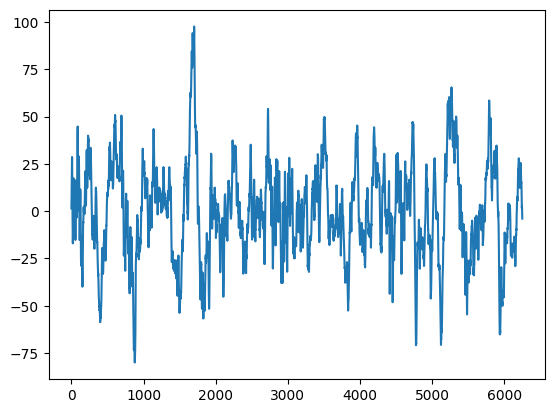

In [17]:
from matplotlib import pyplot as plt
plt.plot(dataset[1000000][0][0].numpy())
plt.show()
# plt.plot(dataset[1][0].squeeze(0).numpy())
# plt.show()
# plt.plot(dataset[2][0].squeeze(0).numpy())
# plt.show()
# plt.plot(dataset[3][0].squeeze(0).numpy())
# plt.show()
# plt.plot(dataset[4][0].squeeze(0).numpy())
# plt.show()

Initialize WandB:

Training:

In [18]:
from torchsummary import summary

# encoder = InceptionBlock(1, config['inception'])
encoder = CNNBlock(1, config['embedding_size'])

transformer = TransformerEncoderWithCLS(
    encoder, 
    config['embedding_size'], 
    config['num_heads'], 
    config['num_layers'], 
    5, 
    dropout=config['dropout'],
    cls=False)
# transformer = SimpleModel(config['seq_len'], 256, 5)

summary(transformer, (1, config['seq_len']))

transformer.to(device)  

# weights = np.unique(dataset.full_labels, return_counts=True)[1] / len(dataset.full_labels)
# weights = 1 / (torch.tensor(weights[:-1], dtype=torch.float) + weights[-1] / 5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer.parameters(), lr=config['lr'])

experiment_name = f"test_sleep_staging_{int(time.time())}" # Add a timestamps to the name

max_epochs = 1000
with wandb.init(project=project_name, entity="milosobral", id=experiment_name, config=config) as wandb_run:
    for i in range(max_epochs):

        print(f"Epoch {i + 1}/{max_epochs}")

        # Training
        start = time.time()
        train_loss, train_acc = train_epoch(transformer, loader, criterion, optimizer, device)
        end = time.time()
        wandb.log({"train_loss": train_loss, "train_acc": train_acc, 'epoch':i})
        print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}, Time: {end - start:.4f}")

        # Validation
        start = time.time()
        test_loss, test_accuracy, conf_mat, class_report = evaluate(transformer, test_loader, criterion)
        end = time.time()
        wandb.log({"test_loss": test_loss, "test_acc": test_accuracy, 'epoch':i, 'class_report': class_report['weighted avg']})
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}, Time: {end - start:.4f}")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Layer (type:depth-idx)                        Output Shape              Param #
├─CNNBlock: 1-1                               [-1, 64, 777]             --
|    └─Conv1d: 2-1                            [-1, 64, 6246]            384
|    └─ReLU: 2-2                              [-1, 64, 6246]            --
|    └─MaxPool1d: 2-3                         [-1, 64, 3123]            --
|    └─Conv1d: 2-4                            [-1, 64, 3119]            20,544
|    └─ReLU: 2-5                              [-1, 64, 3119]            --
|    └─MaxPool1d: 2-6                         [-1, 64, 1559]            --
|    └─Conv1d: 2-7                            [-1, 64, 1555]            20,544
|    └─ReLU: 2-8                              [-1, 64, 1555]            --
|    └─MaxPool1d: 2-9                         [-1, 64, 777]             --
├─Dropout: 1-2                                [-1, 64, 777]             --
├─PositionalEncoding: 1-3                     [-1, 2, 64]               --
|    └─Drop

wandb: Currently logged in as: milosobral. Use `wandb login --relogin` to force relogin


Epoch 1/1000


1000it [02:27,  6.77it/s]                    


Train loss: 142.3394, Train accuracy: 0.5917, Time: 147.6746


1000it [00:39, 25.57it/s]                    


(array([0, 1, 2, 3, 4]), array([25553, 25336, 25872, 25520, 25719]))
Test loss: 119.3354, Test accuracy: 0.6510, Time: 39.3274
Epoch 2/1000


1000it [02:27,  6.77it/s]                    


Train loss: 113.9576, Train accuracy: 0.6713, Time: 147.7458


1000it [00:39, 25.50it/s]                    


(array([0, 1, 2, 3, 4]), array([25755, 25323, 25908, 25538, 25476]))
Test loss: 109.0091, Test accuracy: 0.7002, Time: 39.4361
Epoch 3/1000


1000it [02:26,  6.84it/s]                    


Train loss: 105.6810, Train accuracy: 0.6994, Time: 146.1233


1000it [00:38, 26.02it/s]                    


(array([0, 1, 2, 3, 4]), array([25641, 25479, 25392, 25831, 25657]))
Test loss: 106.2911, Test accuracy: 0.7038, Time: 38.6488
Epoch 4/1000


1000it [02:28,  6.75it/s]                    


Train loss: 100.7509, Train accuracy: 0.7179, Time: 148.1952


1000it [00:39, 25.31it/s]                    


(array([0, 1, 2, 3, 4]), array([25652, 25627, 25576, 25601, 25544]))
Test loss: 105.9202, Test accuracy: 0.7063, Time: 39.7369
Epoch 5/1000


1000it [02:26,  6.81it/s]                    


Train loss: 97.8172, Train accuracy: 0.7286, Time: 146.8483


1000it [00:39, 25.36it/s]                    


(array([0, 1, 2, 3, 4]), array([25907, 25543, 25332, 25654, 25564]))
Test loss: 108.9247, Test accuracy: 0.7011, Time: 39.6611
Epoch 6/1000


1000it [02:29,  6.70it/s]                    


Train loss: 95.5830, Train accuracy: 0.7376, Time: 149.2004


1000it [00:38, 25.68it/s]                    


(array([0, 1, 2, 3, 4]), array([25813, 25340, 25587, 25741, 25519]))
Test loss: 104.8080, Test accuracy: 0.7137, Time: 39.1550
Epoch 7/1000


1000it [02:26,  6.84it/s]                    


Train loss: 93.7503, Train accuracy: 0.7434, Time: 146.1810


1000it [00:38, 26.00it/s]                    


(array([0, 1, 2, 3, 4]), array([25961, 25518, 25679, 25211, 25631]))
Test loss: 109.7674, Test accuracy: 0.6976, Time: 38.6739
Epoch 8/1000


1000it [02:26,  6.84it/s]                    


Train loss: 93.0180, Train accuracy: 0.7458, Time: 146.2629


1000it [00:39, 25.54it/s]                    


(array([0, 1, 2, 3, 4]), array([25325, 25811, 25405, 25954, 25505]))
Test loss: 109.9908, Test accuracy: 0.7021, Time: 39.4142
Epoch 9/1000


1000it [02:28,  6.73it/s]                    


Train loss: 90.9207, Train accuracy: 0.7517, Time: 148.5783


1000it [00:38, 25.69it/s]                    


(array([0, 1, 2, 3, 4]), array([25695, 25668, 25448, 25456, 25733]))
Test loss: 111.8997, Test accuracy: 0.6913, Time: 39.1447
Epoch 10/1000


434it [01:04,  6.74it/s]                     


epoch,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
test_acc,▁▆▇▇▇█▆▇▆
test_loss,█▃▂▂▃▁▃▃▄
train_acc,▁▄▆▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁
epoch,8
test_acc,0.69131
test_loss,111.89973
train_acc,0.75171
train_loss,90.92067


KeyboardInterrupt: 